In [101]:
import sys
from pathlib import Path, PurePath
path = Path.cwd()
parent_path = path.parents[1]
sys.path.append(str(PurePath(parent_path, 'neuroformer')))
sys.path.append('neuroformer')
sys.path.append('.')
sys.path.append('../')

import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import glob
import os
from neuroformer.SpikeVidUtils import trial_df, get_df_visnav, make_intervals, set_trials
import mat73
from neuroformer.SpikeVidUtils import make_intervals, round_n
from neuroformer.utils_2 import set_seed


In [102]:
DATASET = "lateral" 

In [103]:
set_seed(69)

In [104]:
if DATASET == 'medial':
    medial_path = "./data/VisNav_VR_Expt/MedialVRDataset/df.csv"
    test_medial_path = "./data/VisNav_VR_Expt/MedialVRDataset/test_data.csv"
    df = pd.read_csv(medial_path)
    df_test = pd.read_csv(test_medial_path)
    test_intervals = df_test['raw_interval'].unique()
    # np.save("/share/edc/home/antonis/neuroformer/_rebuttal/behavior/regression/medial/medial_intervals_speed.npy", test_intervals)
if DATASET == 'lateral':
    lateral_path = "./data/VisNav_VR_Expt/LateralVRDataset/df.csv"
    test_lateral_path = "./data/VisNav_VR_Expt/LateralVRDataset/test_data.csv"
    df = pd.read_csv(lateral_path)
    df_test = pd.read_csv(test_lateral_path)
    test_intervals = df_test['raw_interval'].unique()
    # np.save("/share/edc/home/antonis/neuroformer/_rebuttal/behavior/regression/lateral/lateral_intervals_speed.npy", test_intervals)

In [106]:
""" 

-- DATA --
neuroformer/data/OneCombo3_V1AL/
df = response
video_stack = stimulus
DOWNLOAD DATA URL = https://drive.google.com/drive/folders/1jNvA4f-epdpRmeG9s2E-2Sfo-pwYbjeY?usp=sharing


"""

from neuroformer.prepare_data import DataLinks
from neuroformer.DataUtils import round_n, split_data_by_interval, get_data_by_interval
from neuroformer.utils_2 import load_config


if DATASET in ["first", "visnav"]:
    data_path = "./data/VisNav_VR_Expt"
elif DATASET == "medial":
    data_path = "./data/VisNav_VR_Expt/MedialVRDataset/"
elif DATASET == "lateral":
    data_path = "./data/VisNav_VR_Expt/LateralVRDataset"

spikes_path = f"{data_path}/NF_1.5/spikerates_dt_0.05.npy"
speed_path = f"{data_path}/NF_1.5/behavior_speed_dt_0.05.npy"
stim_path = f"{data_path}/NF_1.5/stimulus.npy"

spikes = np.load(spikes_path)
speed = np.round(np.load(speed_path), 3)
stimulus = np.load(stim_path)

frame_feats = None
print(f"spikes: {spikes.shape}, speed: {speed.shape}")


config_path = "./configs/NF_1.5/mconf.yaml"
config = load_config(config_path)

intervals = np.arange(0, spikes.shape[1] * config.resolution.dt, config.window.curr)
# train_intervals, test_intervals, finetune_intervals = split_data_by_interval(intervals, r_split=0.8, r_split_ft=0.05)
# choose the intervals not in test_intervals
train_intervals = intervals[~np.isin(intervals, test_intervals)]

spikes: (2023, 30116), speed: (30117,)


In [107]:
len(intervals), len(train_intervals), len(test_intervals)

(6024, 5476, 7165)

In [108]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

target = 'speed'


# Feature scaling
scaler = StandardScaler()
spikes_ = scaler.fit_transform(spikes)

X_train_full, y_train_full = get_data_by_interval(spikes_, train_intervals, 0.05), get_data_by_interval(speed, train_intervals, 0.05) 
X_test, y_test = get_data_by_interval(spikes_, test_intervals, 0.05), get_data_by_interval(speed, test_intervals, 0.05)

X_train_full = X_train_full.transpose(1, 0)
X_test = X_test.transpose(1, 0)


# Initialize Lasso model
ALPHA = 0.01
lasso = Lasso(alpha=ALPHA)

# Define the k-fold cross validator
k = 10
kf = KFold(n_splits=k, random_state=None)

# Placeholders for metrics
r2_scores = []
rmse_scores = []
pearson_correlations = []

# Loop over each fold
# for train_index, val_index in kf.split(X_train_full):
X_train, X_val = X_train_full, X_train_full
y_train, y_val = y_train_full, y_train_full

# Fit the model to the training data
lasso.fit(X_train, y_train)

# Use the model to make predictions on the validation data
predictions_val = lasso.predict(X_val)

# Compute and append R^2 and RMSE for the validation set
r2_scores.append(r2_score(y_val, predictions_val))
rmse_scores.append(np.sqrt(mean_squared_error(y_val, predictions_val)))

# Compute and append Pearson correlation for the validation set
corr, _ = pearsonr(y_val, predictions_val)
pearson_correlations.append(corr)

# Compute the average scores
mean_r2 = np.mean(r2_scores)
mean_rmse = np.mean(rmse_scores)
mean_corr = np.mean(pearson_correlations)
std_corr = np.std(pearson_correlations)

# Print the average scores
print('Average R^2 score: ', mean_r2)
print('Average RMSE: ', mean_rmse)
print('Average Pearsons correlation: ', mean_corr)

# Finally, you can evaluate the model on the test set
predictions_test = lasso.predict(X_test)
print('Test R^2 score: ', r2_score(y_test, predictions_test))
print('Test RMSE: ', np.sqrt(mean_squared_error(y_test, predictions_test)))
corr, _ = pearsonr(y_test, predictions_test)
print('Test Pearsons correlation: ', corr)

Average R^2 score:  0.5420959481160411
Average RMSE:  0.5198540149858374
Average Pearsons correlation:  0.7468116858376781
Test R^2 score:  0.29803952945222556
Test RMSE:  0.8666964983070959
Test Pearsons correlation:  0.6219629289711589


Text(0.20681168583767812, 0.8925000000000001, 'Std: 0.00')

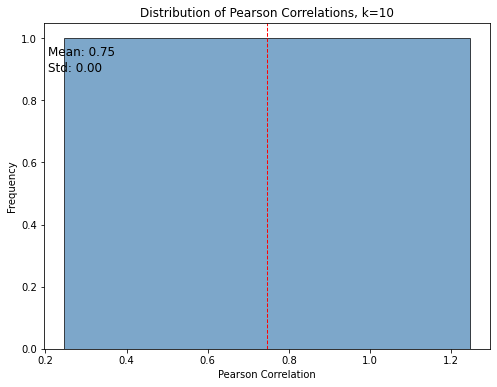

In [109]:
# Plot the distribution of Pearson correlations
plt.figure(figsize=(8, 6))
plt.hist(pearson_correlations, bins='auto', alpha=0.7, color='steelblue', edgecolor='black')
plt.title(f'Distribution of Pearson Correlations, k={k}')
plt.xlabel('Pearson Correlation')
plt.ylabel('Frequency')

# Overlay mean and std on the plot
plt.axvline(mean_corr, color='red', linestyle='dashed', linewidth=1)

# Get the limits of x and y axes
xlim = plt.xlim()
ylim = plt.ylim()

# Position the text at the top left corner
plt.text(xlim[0] + 0.01, ylim[1] - (ylim[1] - ylim[0]) * 0.1, f'Mean: {mean_corr:.2f}', fontsize=12)
plt.text(xlim[0] + 0.01, ylim[1] - (ylim[1] - ylim[0]) * 0.15, f'Std: {std_corr:.2f}', fontsize=12)


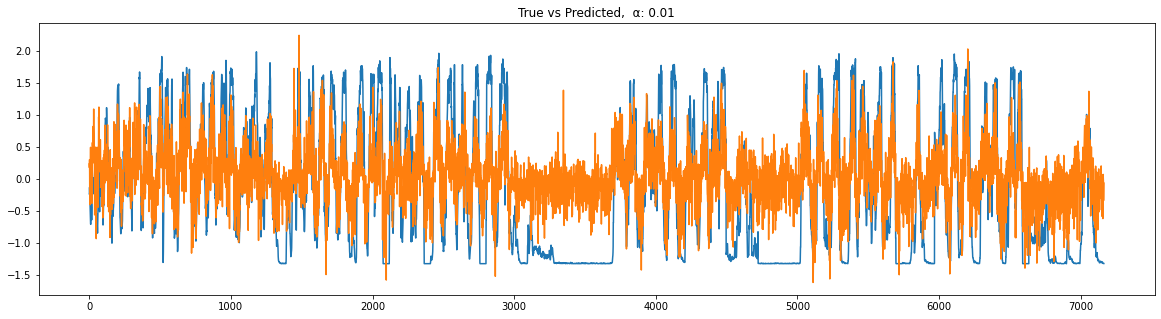

In [110]:
# plot true and predicted
x_axis = np.arange(len(y_test))

plt.figure(figsize=(20, 5))
plt.title(f'True vs Predicted,  α: {ALPHA}')
plt.plot(x_axis, y_test, label='True')
plt.plot(x_axis, predictions_test, label='Predicted')

In [111]:
save_path = f"_rebuttal/behavior/regression/{DATASET}"
lasso_save_path = os.path.join(save_path, "lasso")
if not os.path.exists(lasso_save_path):
    os.makedirs(lasso_save_path)

df_predictions = pd.DataFrame({'behavior': predictions_test, 'true': y_test, 'Interval': test_intervals})

# save_path
df_predictions.to_csv(os.path.join(lasso_save_path, "lasso_behavior.csv"), index=False)

In [112]:
import statsmodels.api as sm

# firing_counts_df_glm['speed'] += firing_counts_df_glm['speed'].min() + 1

y = speed

# Drop the 'target' column from firing_counts_df to avoid leakage
X_train_glm, Y_train_glm = get_data_by_interval(spikes, train_intervals, 0.05), get_data_by_interval(speed, train_intervals, 0.05) 
X_test_glm, Y_test_glm = get_data_by_interval(spikes, test_intervals, 0.05), get_data_by_interval(speed, test_intervals, 0.05)

X_train_glm = X_train_glm.transpose(1, 0)
X_test_glm = X_test_glm.transpose(1, 0)

# scale features
# scaler = StandardScaler()
# X_train_glm = scaler.fit_transform(X_train_glm)
# X_test_glm = scaler.transform(X_test_glm)

# Define the GLM model, assuming a Gaussian distribution
model = sm.GLM(Y_train_glm, X_train_glm, family=sm.families.Gaussian())

# Fit the model
results = model.fit()

# Use the model to make predictions on the test data
predictions = results.predict(X_test_glm)

# Print the model summary
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 5476
Model:                            GLM   Df Residuals:                     3632
Model Family:                Gaussian   Df Model:                         1843
Link Function:               Identity   Scale:                         0.33226
Method:                          IRLS   Log-Likelihood:                -3625.6
Date:                Sun, 06 Aug 2023   Deviance:                       1205.2
Time:                        17:37:56   Pearson chi2:                 1.21e+03
No. Iterations:                   100   Pseudo R-squ. (CS):             0.6952
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1405      0.081      1.736      0.0

In [113]:
df_predictions_glm = pd.DataFrame({'behavior': predictions, 'true': Y_test_glm, 'Interval': test_intervals})
glm_save_path = os.path.join(save_path, "glm")
if not os.path.exists(glm_save_path):
    os.makedirs(glm_save_path)
df_predictions_glm.to_csv(os.path.join(glm_save_path, "glm_behavior.csv"), index=False)

In [114]:
save_path

'_rebuttal/behavior/regression/lateral'

In [115]:
pearsonr(Y_test_glm, predictions)

PearsonRResult(statistic=0.26162116295924764, pvalue=1.8839689892946028e-112)

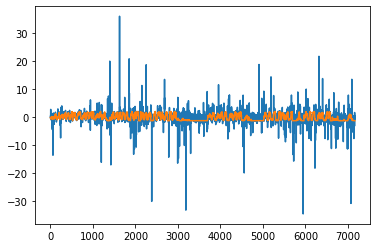

In [116]:
x_axis = np.arange(len(predictions))
plt.plot(x_axis, predictions, label="Predicted")
plt.plot(x_axis, y_test, label="Actual")